In [21]:
import numpy as np
from matplotlib import pyplot as plt

## Задание 1

### Задача 1 (Реализуйте слой BatchNorm (nn.BatchNorm).)

In [22]:
class BatchNorm:
    def __init__(self, num_features, eps=1e-5, momentum=0.9):
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum

        # Параметры для скалирования и смещения
        self.gamma = np.ones(num_features)
        self.beta = np.zeros(num_features)

        # Движущиеся средние и дисперсии для режима inference
        self.running_mean = np.zeros(num_features)
        self.running_var = np.ones(num_features)

    def forward(self, x, train=True):
        if train:
            # 1. Вычисляем среднее и дисперсию по батчу
            batch_mean = np.mean(x, axis=0)
            batch_var = np.var(x, axis=0)

            # 2. Нормализуем данные
            self.x_hat = (x - batch_mean) / np.sqrt(batch_var + self.eps)

            # Сохраняем средние и дисперсии для backward pass
            self.batch_mean = batch_mean
            self.batch_var = batch_var
            self.x = x

            # 3. Применяем скалирование и смещение
            y = self.gamma * self.x_hat + self.beta

            # 4. Обновляем движущиеся средние и дисперсии
            self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * batch_mean
            self.running_var = self.momentum * self.running_var + (1 - self.momentum) * batch_var
        else:
            # Используем движущиеся средние и дисперсии для инференса
            self.x_hat = (x - self.running_mean) / np.sqrt(self.running_var + self.eps)
            y = self.gamma * self.x_hat + self.beta

        return y

    def backward(self, grad_output):
        """
        Обратное распространение через BatchNorm.
        Аргументы:
        grad_output -- градиенты от следующего слоя

        Возвращает:
        grad_input -- градиенты для предыдущего слоя
        """
        m = grad_output.shape[0]

        # Градиенты по параметрам γ и β
        grad_gamma = np.sum(grad_output * self.x_hat, axis=0)
        grad_beta = np.sum(grad_output, axis=0)

        # Градиенты по нормализованным входам x_hat
        grad_x_hat = grad_output * self.gamma

        # Градиенты по дисперсии σ^2
        grad_var = np.sum(grad_x_hat * (self.x - self.batch_mean) * -0.5 * np.power(self.batch_var + self.eps, -1.5),
                          axis=0)

        # Градиенты по среднему μ
        grad_mean = np.sum(grad_x_hat * -1 / np.sqrt(self.batch_var + self.eps), axis=0) + grad_var * np.mean(
            -2 * (self.x - self.batch_mean), axis=0)

        # Градиенты по входам x
        grad_input = grad_x_hat / np.sqrt(self.batch_var + self.eps) + grad_var * 2 * (
                    self.x - self.batch_mean) / m + grad_mean / m

        return grad_input, grad_gamma, grad_beta

    def __call__(self, x, train=True):
        return self.forward(x, train)

In [23]:
activations = np.random.lognormal(mean=0, sigma=1, size=(1000, 100))
bn = BatchNorm(num_features=100)
output = bn(activations, train=True)


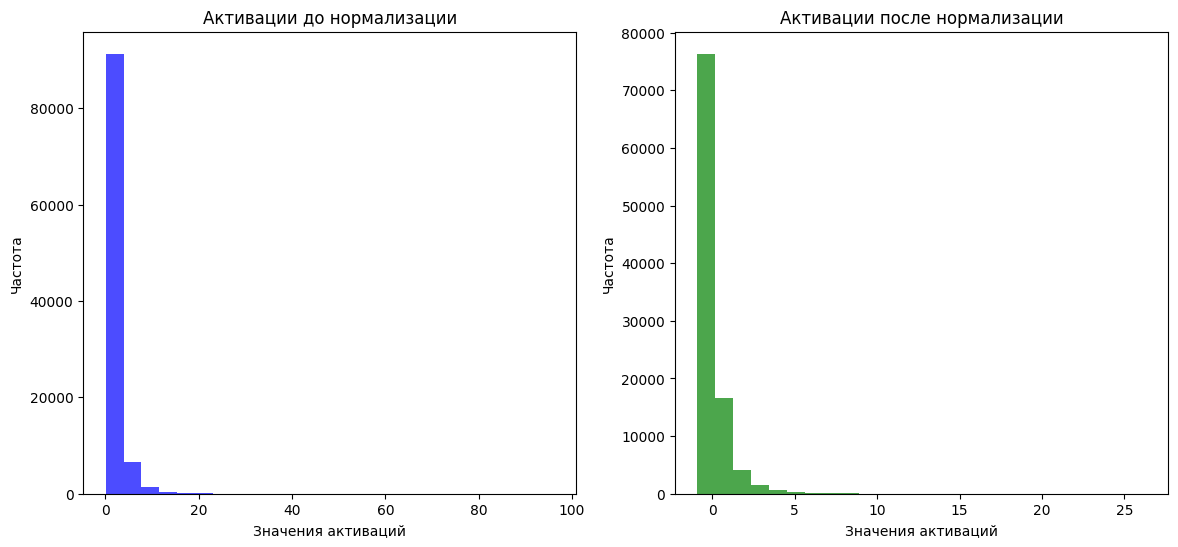

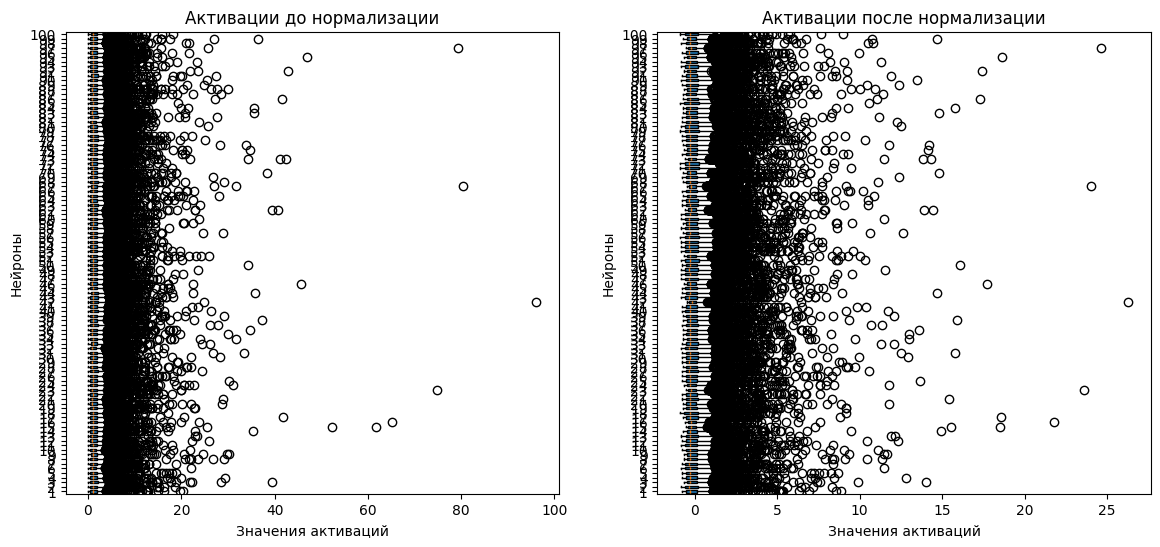

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].hist(activations.flatten(), bins=25, color='blue', alpha=0.7)
axs[0].set_title("Активации до нормализации")
axs[0].set_xlabel("Значения активаций")
axs[0].set_ylabel("Частота")

axs[1].hist(output.flatten(), bins=25, color='green', alpha=0.7)
axs[1].set_title("Активации после нормализации")
axs[1].set_xlabel("Значения активаций")
axs[1].set_ylabel("Частота")

plt.show()

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].boxplot(activations, vert=False, patch_artist=True)
axs[0].set_title("Активации до нормализации")
axs[0].set_xlabel("Значения активаций")
axs[0].set_ylabel("Нейроны")

axs[1].boxplot(output, vert=False, patch_artist=True)
axs[1].set_title("Активации после нормализации")
axs[1].set_xlabel("Значения активаций")
axs[1].set_ylabel("Нейроны")

plt.show()

#### Нормализация помогает выровнять основную массу данных ближе к нулю и уменьшает разброс, что облегчает обучение модели.

### Задача 2 (Реализуйте слой Linear (nn.Linear).)

In [25]:
import numpy as np


class Linear:
    def __init__(self, input_size, output_size):
        # Инициализация весов и смещений
        self.weights = np.random.randn(output_size, input_size) * 0.01
        self.bias = np.zeros(output_size)

        # Градиенты для весов и смещений
        self.grad_weights = None
        self.grad_bias = None

    def forward(self, x):
        """
        Прямой проход через линейный слой.
        Аргументы:
        x -- входные данные размером (batch_size, input_size)

        Возвращает:
        y -- выходные данные размером (batch_size, output_size)
        """
        self.x = x  # Сохраняем входные данные для обратного прохода
        return np.dot(x, self.weights.T) + self.bias

    def backward(self, grad_output):
        """
        Обратное распространение.
        Аргументы:
        grad_output -- градиенты от следующего слоя размером (batch_size, output_size)

        Возвращает:
        grad_input -- градиенты для предыдущего слоя (batch_size, input_size)
        """
        # Количество примеров в батче
        batch_size = self.x.shape[0]

        # Градиенты по весам и смещениям
        self.grad_weights = np.dot(grad_output.T, self.x) / batch_size  # dL/dW
        self.grad_bias = np.mean(grad_output, axis=0)  # dL/db

        # Градиенты для входов, чтобы передать их на предыдущий слой
        grad_input = np.dot(grad_output, self.weights)  # dL/dx
        return grad_input

    def update_params(self, learning_rate):
        """
        Обновление параметров (весов и смещений).
        Аргументы:
        learning_rate -- скорость обучения для обновления параметров
        """
        self.weights -= learning_rate * self.grad_weights
        self.bias -= learning_rate * self.grad_bias

    def __call__(self, x):
        return self.forward(x)


# Пример использования:
input_size = 100  # Количество входных признаков (например, 4 признака)
output_size = 10  # Количество нейронов в слое (например, 3 нейрона)

# Создаем линейный слой
linear_layer = Linear(input_size, output_size)

output2 = linear_layer(activations)

# Градиенты от следующего слоя (например, от функции потерь)
grad_output = np.random.randn(1000, output_size)

# Обратное распространение (backward)
grad_input = linear_layer.backward(grad_output)
print("Градиенты для входов:")
#print(grad_input)


Градиенты для входов:


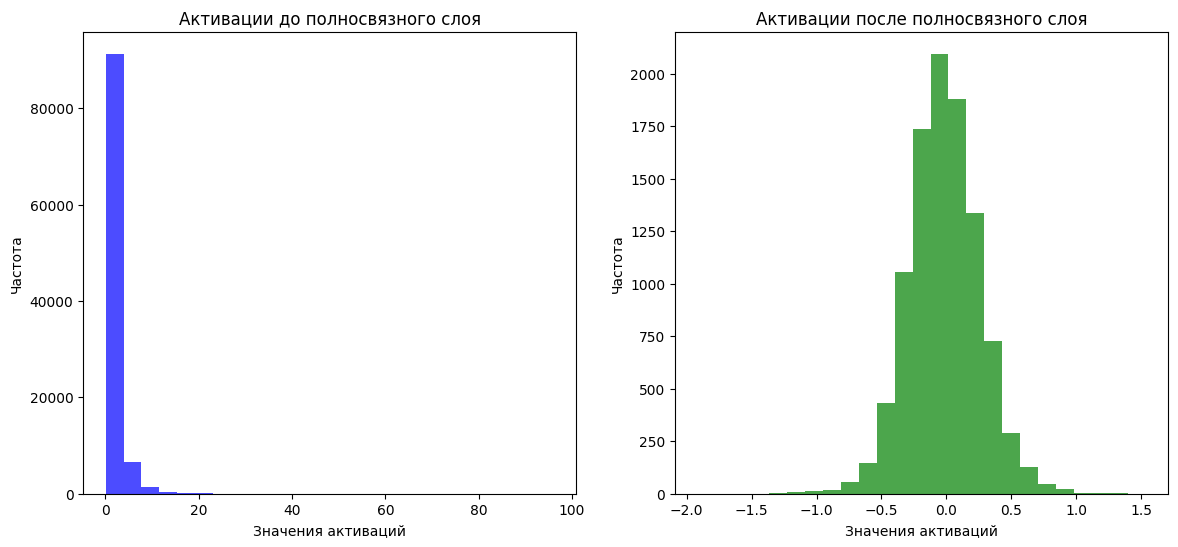

Text(0, 0.5, 'Нейроны')

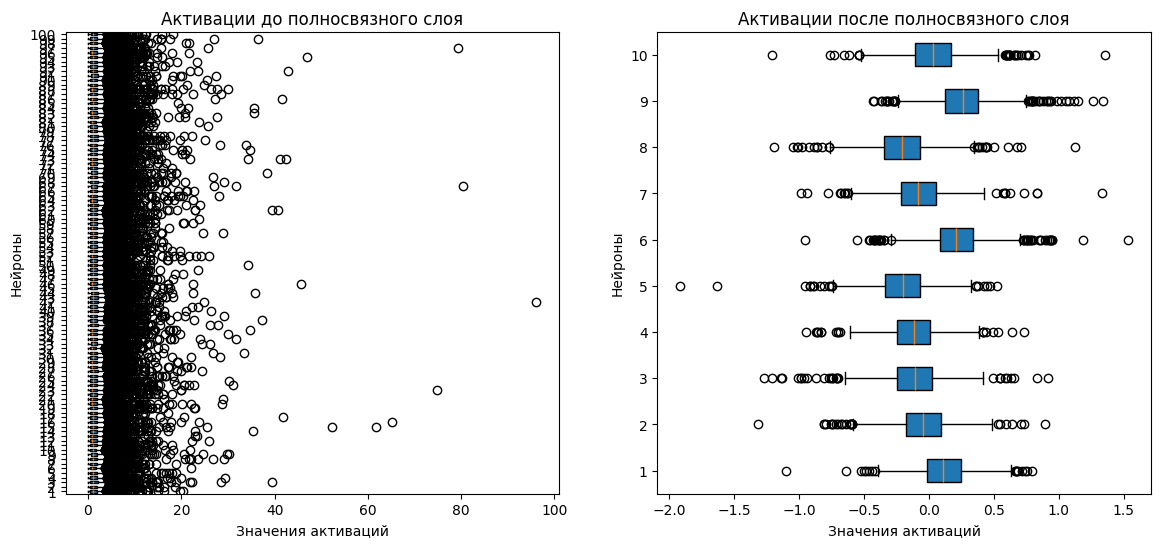

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].hist(activations.flatten(), bins=25, color='blue', alpha=0.7)
axs[0].set_title("Активации до полносвязного слоя")
axs[0].set_xlabel("Значения активаций")
axs[0].set_ylabel("Частота")

axs[1].hist(output2.flatten(), bins=25, color='green', alpha=0.7)
axs[1].set_title("Активации после полносвязного слоя")
axs[1].set_xlabel("Значения активаций")
axs[1].set_ylabel("Частота")

plt.show()

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].boxplot(activations, vert=False, patch_artist=True)
axs[0].set_title("Активации до полносвязного слоя")
axs[0].set_xlabel("Значения активаций")
axs[0].set_ylabel("Нейроны")

axs[1].boxplot(output2, vert=False, patch_artist=True)
axs[1].set_title("Активации после полносвязного слоя")
axs[1].set_xlabel("Значения активаций")
axs[1].set_ylabel("Нейроны")

### Задача 3 (Реализуйте слой Dropout(nn.Dropout))

In [27]:
import numpy as np


class Dropout:
    def __init__(self, p=0.5):
        """
        Инициализация слоя Dropout.
        Аргументы:
        p -- вероятность "выключения" нейрона (по умолчанию 0.5)
        """
        self.p = p  # вероятность отключения нейрона
        self.mask = None  # маска, которая будет использована для отключения

    def forward(self, x, train=True):
        """
        Прямой проход (forward pass) через слой Dropout.
        Аргументы:
        x -- входные данные (активации от предыдущего слоя)
        train -- индикатор, находится ли модель в режиме обучения

        Возвращает:
        y -- выходные данные после применения Dropout
        """
        if train:
            # Генерируем маску: 1 с вероятностью (1 - p), 0 с вероятностью p
            self.mask = (np.random.rand(*x.shape) > self.p).astype(np.float32)
            # Применяем маску и масштабируем
            return (x * self.mask) / (1 - self.p)
        else:
            # В режиме инференса (предсказаний) Dropout не применяется
            return x

    def backward(self, grad_output):
        """
        Обратное распространение через слой Dropout.
        Аргументы:
        grad_output -- градиенты от следующего слоя

        Возвращает:
        grad_input -- градиенты для предыдущего слоя
        """
        # Применяем маску к градиентам и масштабируем
        grad_input = grad_output * self.mask / (1 - self.p)
        return grad_input

    def __call__(self, x, train=True):
        return self.forward(x, train)


# Пример использования:
dropout_layer = Dropout(p=0.3)

# Входные данные (например, батч из 4 примеров, каждый с 5 признаками)
x = np.array([[1, 2, 3, 4, 5],
              [5, 4, 3, 2, 1],
              [1, 3, 5, 7, 9],
              [9, 7, 5, 3, 1]])

# Применяем Dropout в режиме обучения
output_train = dropout_layer(x, train=True)
print("Выход после Dropout (режим обучения):")
print(output_train)

# Применяем Dropout в режиме предсказаний
output_inference = dropout_layer(x, train=False)
print("Выход после Dropout (режим предсказаний):")
print(output_inference)


Выход после Dropout (режим обучения):
[[ 0.          2.85714286  4.28571429  5.71428571  7.14285714]
 [ 7.14285714  0.          4.28571429  2.85714286  0.        ]
 [ 1.42857143  4.28571429  0.         10.          0.        ]
 [12.85714286 10.          7.14285714  4.28571429  1.42857143]]
Выход после Dropout (режим предсказаний):
[[1 2 3 4 5]
 [5 4 3 2 1]
 [1 3 5 7 9]
 [9 7 5 3 1]]


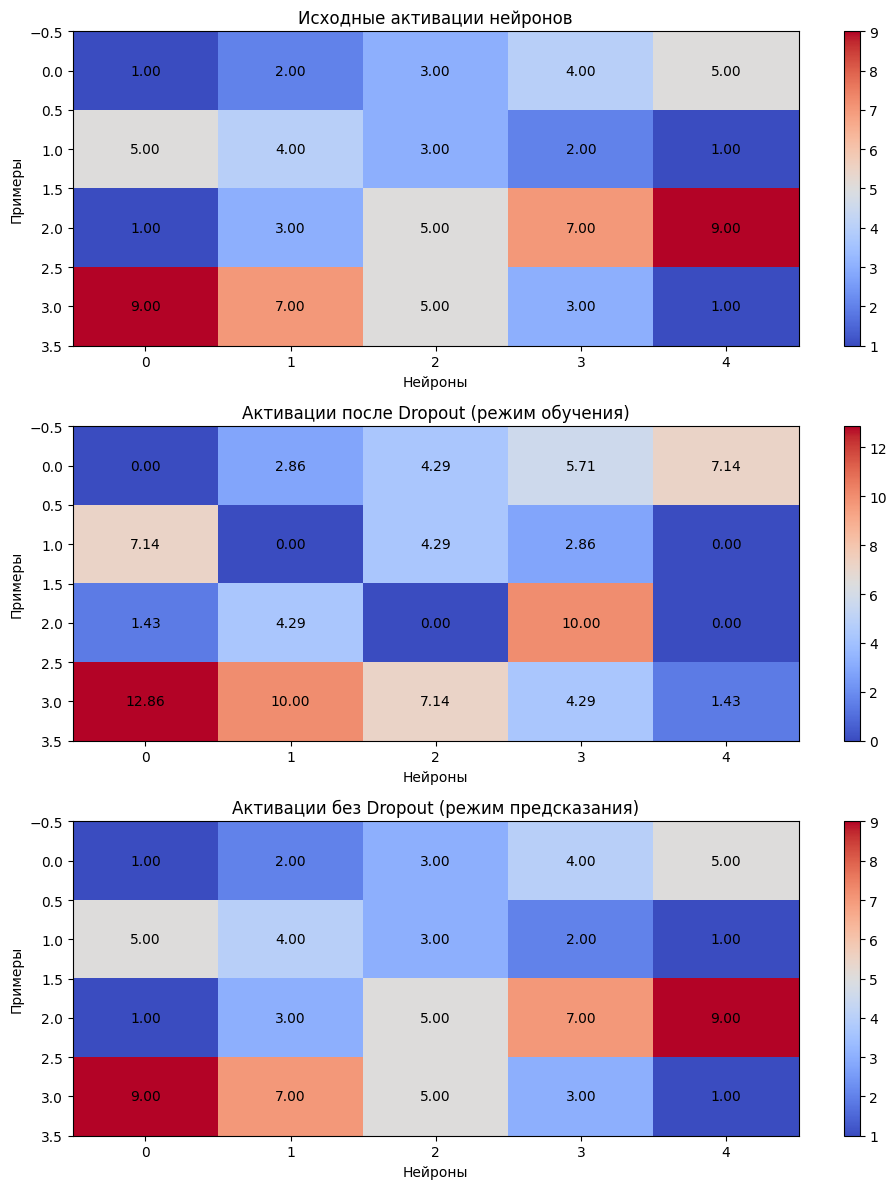

In [28]:
# Добавляем текстовые значения активаций на графики
fig, axs = plt.subplots(3, 1, figsize=(10, 12))


def add_values_to_cells(ax, data):
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            ax.text(j, i, f"{data[i, j]:.2f}", ha='center', va='center', color='black')


# Исходные активации
im0 = axs[0].imshow(x, cmap="coolwarm", aspect='auto')
axs[0].set_title("Исходные активации нейронов")
axs[0].set_ylabel("Примеры")
axs[0].set_xlabel("Нейроны")
add_values_to_cells(axs[0], x)
plt.colorbar(im0, ax=axs[0])

# Активации после применения Dropout (режим обучения)
im1 = axs[1].imshow(output_train, cmap="coolwarm", aspect='auto')
axs[1].set_title("Активации после Dropout (режим обучения)")
axs[1].set_ylabel("Примеры")
axs[1].set_xlabel("Нейроны")
add_values_to_cells(axs[1], output_train)
plt.colorbar(im1, ax=axs[1])

# Активации без Dropout (режим предсказания)
im2 = axs[2].imshow(output_inference, cmap="coolwarm", aspect='auto')
axs[2].set_title("Активации без Dropout (режим предсказания)")
axs[2].set_ylabel("Примеры")
axs[2].set_xlabel("Нейроны")
add_values_to_cells(axs[2], output_inference)
plt.colorbar(im2, ax=axs[2])

plt.tight_layout()
plt.show()


### Задача 4 (слой ReLU(nn.ReLU))

In [29]:
class ReLU:
    def __init__(self):
        pass

    def forward(self, x):
        """
        Прямой проход (forward pass) через ReLU.
        Аргументы:
        x -- входные данные (массив numpy)

        Возвращает:
        y -- выходные данные после применения ReLU
        """
        self.x = x
        return np.maximum(0, x)

    def backward(self, grad_output):
        """
        Обратное распространение через ReLU.
        Аргументы:
        grad_output -- градиенты от следующего слоя

        Возвращает:
        grad_input -- градиенты для предыдущего слоя
        """
        grad_input = grad_output * (self.x > 0)  # Передаем градиент только для положительных входов
        return grad_input

    def __call__(self, x):
        return self.forward(x)


# Пример использования:
relu_layer = ReLU()

# Входные данные
x = np.array([[1, -2, 3],
              [-1, 2, 0]])

# Прямой проход через ReLU
output = relu_layer(x)
print("Выход ReLU (forward):")
print(output)

# Пример градиента от следующего слоя
grad_output = np.array([[1, 1, 1],
                        [1, 1, 1]])

# Обратное распространение через ReLU
grad_input = relu_layer.backward(grad_output)
print("Градиенты ReLU (backward):")
print(grad_input)

Выход ReLU (forward):
[[1 0 3]
 [0 2 0]]
Градиенты ReLU (backward):
[[1 0 1]
 [0 1 0]]


## Задание 3.Реализуйте следующие классы (указана сигнатура init):

### BaseTransform(p: float) [базовый класс для всех трансформаций]

In [42]:
from PIL import Image
import numpy as np
class BaseTransform:
    def __init__(self, p: float):
        """
        Базовый класс для всех трансформаций.
        Аргументы:
        p -- вероятность применения трансформации (float, между 0 и 1)
        """
        self.p = p

    def pil_to_numpy(self, img):
        """
        Преобразует изображение PIL.Image в NumPy массив.
        Этот метод доступен для всех наследуемых классов.
        """
        if isinstance(img, Image.Image):
            return np.array(img)
        else:
            raise TypeError("Ожидался тип данных PIL.Image, получен: {}".format(type(img)))

    def numpy_to_pil(self, array):
        """
        Преобразует NumPy массив обратно в PIL.Image.
        Этот метод доступен для всех наследуемых классов.
        """
        if isinstance(array, np.ndarray):
            return Image.fromarray(array.astype(np.uint8))
        else:
            raise TypeError("Ожидался тип данных numpy.ndarray, получен: {}".format(type(array)))

    def apply_transform(self, x):
        """
        Метод для применения трансформации. В базовом классе просто проверяет вероятность применения.
        Должен быть переопределен в дочерних классах.
        """
        if np.random.rand() < self.p:
            return self.transform(x)
        else:
            return x

    def transform(self, x):
        """
        Метод для трансформации данных. В базовом классе пуст, должен быть переопределён в дочерних классах.
        """
        raise NotImplementedError("Метод 'transform' должен быть переопределен в дочерних классах.")

### RandomCrop(p: float, **kwargs)

In [59]:
class RandomCrop(BaseTransform):
    def __init__(self, p: float, crop_height: int, crop_width: int, resize_height: int, resize_width: int):
        """
        Инициализация класса RandomCrop.
        Аргументы:
        p -- вероятность применения трансформации (float, между 0 и 1)
        crop_height -- высота области обрезки
        crop_width -- ширина области обрезки
        resize_height -- высота, до которой нужно изменить размер после обрезки
        resize_width -- ширина, до которой нужно изменить размер после обрезки
        """
        super().__init__(p)
        self.crop_height = crop_height
        self.crop_width = crop_width
        self.resize_height = resize_height
        self.resize_width = resize_width

    def transform(self, x):
        """
        Применение случайной обрезки к изображению, а затем изменение размера до исходного.
        Аргументы:
        x -- данные в формате PIL.Image или NumPy массив

        Возвращает:
        Изображение после обрезки и изменения размера
        """
        is_pil = False
        if isinstance(x, Image.Image):
            is_pil = True
            x = self.pil_to_numpy(x)

        img_height, img_width = x.shape[:2]

        # Проверка на то, что обрезка не больше исходных размеров
        if self.crop_height > img_height or self.crop_width > img_width:
            raise ValueError("Размер обрезки превышает размеры изображения")

        # Случайные координаты для обрезки
        top = np.random.randint(0, img_height - self.crop_height + 1)
        left = np.random.randint(0, img_width - self.crop_width + 1)

        # Выполняем обрезку
        cropped_x = x[top:top + self.crop_height, left:left + self.crop_width]

        # Изменение размера после обрезки до исходного размера
        if is_pil:
            cropped_x = self.numpy_to_pil(cropped_x)
            resized_x = cropped_x.resize((self.resize_width, self.resize_height), Image.ANTIALIAS)
        else:
            resized_x = np.array(Image.fromarray(cropped_x.astype(np.uint8)).resize((self.resize_width, self.resize_height), Image.ANTIALIAS))

        return resized_x

### RandomRotate(p: float, **kwargs)

In [60]:
from scipy.ndimage import rotate
class RandomRotate(BaseTransform):
    def __init__(self, p: float, angle_range: tuple = (-180, 180)):
        """
        Инициализация класса RandomRotate.
        Аргументы:
        p -- вероятность применения поворота (float, между 0 и 1)
        angle_range -- диапазон углов для случайного поворота (по умолчанию от -180 до 180 градусов)
        """
        super().__init__(p)
        self.angle_range = angle_range

    def transform(self, x):
        """
        Применение случайного поворота к данным (например, изображению).
        Аргументы:
        x -- данные (например, изображение в виде numpy массива)

        Возвращает:
        Трансформированные данные (поворот на случайный угол)
        """
        is_pil = False
        if isinstance(x, Image.Image):
            is_pil = True
            x = self.pil_to_numpy(x)

        # Генерируем случайный угол
        angle = np.random.uniform(*self.angle_range)

        # Поворачиваем данные на случайный угол
        rotated_x = rotate(x, angle, reshape=False, mode='nearest')

        if is_pil:
            return self.numpy_to_pil(rotated_x)
        return rotated_x

# Пример использования:
random_rotate = RandomRotate(p=0.7, angle_range=(-45, 45))


### ToTensor()

In [61]:
import torch
class ToTensor(BaseTransform):
    def __init__(self):
        """
        Инициализация класса ToTensor.
        По умолчанию p=1.0, так как преобразование всегда нужно применять.
        """
        super().__init__(p=1.0)

    def transform(self, x):
        """
        Преобразование PIL.Image или NumPy массива в тензор.
        Аргументы:
        x -- данные в формате PIL.Image или NumPy массив

        Возвращает:
        PyTorch тензор.
        """
        if isinstance(x, Image.Image):
            x = self.pil_to_numpy(x)  # Используем метод из BaseTransform
        if isinstance(x, np.ndarray):
            x = torch.tensor(x, dtype=torch.float32) / 255.0  # Преобразуем в тензор и нормализуем
            if x.ndim == 2:  # Если это изображение без цветового канала, добавим ось канала
                x = x.unsqueeze(0)
            elif x.ndim == 3:  # Переставим оси, чтобы они соответствовали формату (C, H, W)
                x = x.permute(2, 0, 1)
            return x
        else:
            raise TypeError("Ожидался тип данных PIL.Image или numpy.ndarray, получен: {}".format(type(x)))

In [62]:
class Compose:
    def __init__(self, transforms: list):
        """
        Инициализация класса Compose.
        Аргументы:
        transforms -- список объектов, унаследованных от BaseTransform
        """
        self.transforms = transforms

    def __call__(self, x):
        """
        Применение всех трансформаций из списка последовательно.
        Аргументы:
        x -- изображение (PIL.Image или NumPy массив)

        Возвращает:
        Трансформированное изображение после последовательного применения всех трансформаций.
        """
        for transform in self.transforms:
            x = transform.apply_transform(x)  # Применяем каждую трансформацию с учетом вероятности p
        return x


In [64]:
image = Image.open('image.jpg')
w,h = image.size


# Создаем экземпляры трансформаций
random_crop = RandomCrop(p=0.8, crop_height=int(h * 1/2), crop_width=int(w*1/2),resize_height=h,resize_width=w)
random_rotate = RandomRotate(p=0.7, angle_range=(-45, 45))
to_tensor = ToTensor()

# Объединяем их в Compose
composed_transforms = Compose([random_crop, random_rotate])

# Открываем изображение с помощью PIL
image = Image.open('image.jpg')

# Применяем все трансформации последовательно
transformed_image = composed_transforms(image)


if isinstance(transformed_image, torch.Tensor):
    print("Результат: тензор")
else:
    print("Результат: изображение")

if isinstance(transformed_image, Image.Image):
    transformed_image.save('transformed_image.jpg')


C:\Users\user\AppData\Local\Temp\ipykernel_5300\880928060.py:48: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  resized_x = cropped_x.resize((self.resize_width, self.resize_height), Image.ANTIALIAS)


Результат: изображение


## Задание 4

In [65]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt


In [66]:
# Трансформации для Fashion-MNIST
train_transforms = Compose([
    RandomCrop(p=0.8, crop_height=14, crop_width=14, resize_height=28, resize_width=28),  # Обрезка и изменение размера
    RandomRotate(p=0.7, angle_range=(-45, 45)),  # Случайный поворот
    ToTensor()
])

test_transforms = Compose([
    ToTensor()  # Минимальные трансформации для тестовых данных
])


In [67]:
# Загрузка датасета Fashion-MNIST
train_dataset = datasets.FashionMNIST(
    root='./data', train=True, download=True, transform=train_transforms
)

test_dataset = datasets.FashionMNIST(
    root='./data', train=False, download=True, transform=test_transforms
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [79]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.fc1 = nn.Linear(32 * 14 * 14, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(torch.relu(self.conv2(x)), 2)
        # Преобразование размерности перед подачей в полносвязный слой
        # Важно: убедитесь, что не изменяете размер батча
        x = x.view(x.size(0), -1)  # x.size(0) гарантирует, что размер батча остаётся прежним
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

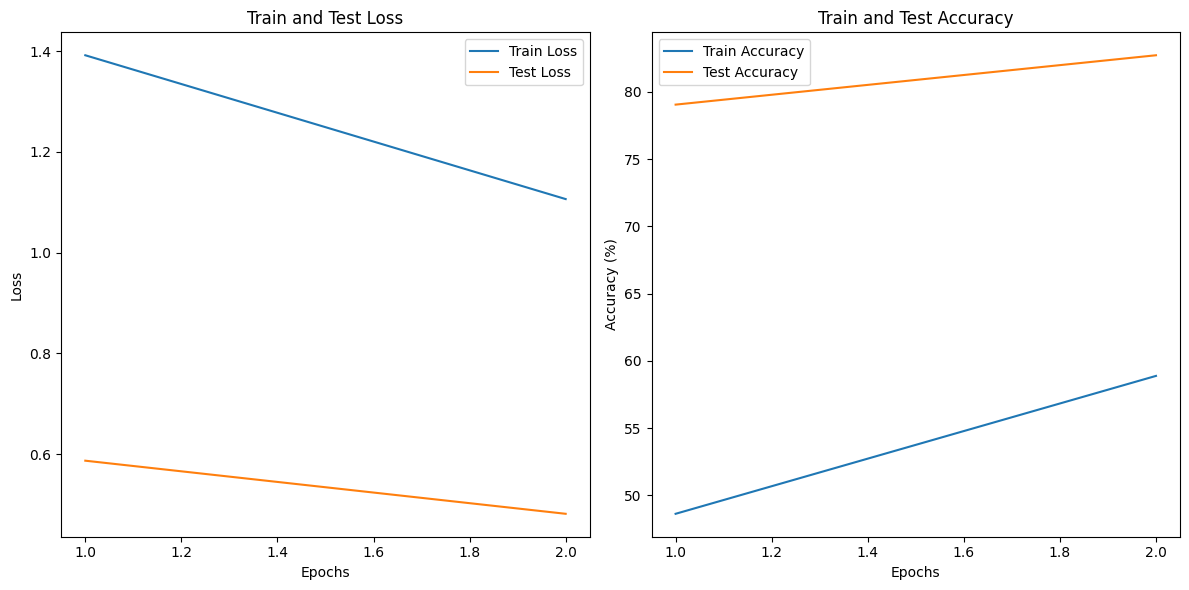

In [82]:
# Построение графиков изменения лосса и точности
epochs_range = range(1, num_epochs + 1)

plt.figure(figsize=(12, 6))

# Лосс
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Test Loss')
plt.legend()

# Точность
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Train and Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [84]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms

# Определение устройства
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Модель
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.fc1 = nn.Linear(32 * 14 * 14, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(torch.relu(self.conv2(x)), 2)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Создаем модель и переносим на GPU, если он доступен
model = SimpleCNN().to(device)

# Задаем трансформации и загружаем данные Fashion-MNIST
train_dataset = datasets.FashionMNIST(
    root='./data', train=True, download=True, transform=transforms.ToTensor()
)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = datasets.FashionMNIST(
    root='./data', train=False, download=True, transform=transforms.ToTensor()
)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Функция потерь и оптимизатор
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Функция для обучения
def train_model(model, train_loader, criterion, optimizer, device, epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)  # Перенос данных на GPU

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        # Выводим результаты каждые 100 батчей
        if batch_idx % 100 == 0:
            print(f'Epoch: {epoch}, Batch: {batch_idx}, Loss: {loss.item():.4f}, Accuracy: {100.*correct/total:.2f}%')

    accuracy = 100. * correct / total
    return train_loss / len(train_loader), accuracy

# Функция для тестирования
def test_model(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    accuracy = 100. * correct / total
    return test_loss / len(test_loader), accuracy

# Обучение
num_epochs = 5

for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device, epoch)
    test_loss, test_acc = test_model(model, test_loader, criterion, device)

    print(f'Epoch {epoch}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, '
          f'Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%')


Epoch: 1, Batch: 0, Loss: 2.3078, Accuracy: 15.62%
Epoch: 1, Batch: 100, Loss: 0.5563, Accuracy: 70.87%
Epoch: 1, Batch: 200, Loss: 0.3061, Accuracy: 76.33%
Epoch: 1, Batch: 300, Loss: 0.3998, Accuracy: 79.10%
Epoch: 1, Batch: 400, Loss: 0.3900, Accuracy: 80.78%
Epoch: 1, Batch: 500, Loss: 0.4974, Accuracy: 81.95%
Epoch: 1, Batch: 600, Loss: 0.3511, Accuracy: 82.84%
Epoch: 1, Batch: 700, Loss: 0.5117, Accuracy: 83.57%
Epoch: 1, Batch: 800, Loss: 0.2250, Accuracy: 84.17%
Epoch: 1, Batch: 900, Loss: 0.2721, Accuracy: 84.60%
Epoch 1/5, Train Loss: 0.4292, Test Loss: 0.3424, Train Acc: 84.75%, Test Acc: 87.47%
Epoch: 2, Batch: 0, Loss: 0.3336, Accuracy: 82.81%
Epoch: 2, Batch: 100, Loss: 0.2784, Accuracy: 89.65%
Epoch: 2, Batch: 200, Loss: 0.0709, Accuracy: 89.67%
Epoch: 2, Batch: 300, Loss: 0.2696, Accuracy: 89.62%
Epoch: 2, Batch: 400, Loss: 0.1891, Accuracy: 89.72%
Epoch: 2, Batch: 500, Loss: 0.2338, Accuracy: 89.84%
Epoch: 2, Batch: 600, Loss: 0.2694, Accuracy: 89.91%
Epoch: 2, Batch: 

In [87]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Определение устройства (GPU или CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Ваша модель
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.fc1 = nn.Linear(32 * 14 * 14, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(torch.relu(self.conv2(x)), 2)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Функции для тренировки и тестирования
def train_model(model, train_loader, criterion, optimizer, device, epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    accuracy = 100. * correct / total
    return train_loss / len(train_loader), accuracy

def test_model(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    accuracy = 100. * correct / total
    return test_loss / len(test_loader), accuracy

# Определяем две версии трансформаций
# 1. Ваша версия с трансформациями
train_transforms_with_aug = Compose([
    RandomCrop(p=0.8, crop_height=14, crop_width=14, resize_height=28, resize_width=28),  # Обрезка и изменение размера
    RandomRotate(p=0.7, angle_range=(-45, 45)),  # Случайный поворот
    ToTensor()
])

# 2. Версия без трансформаций (только ToTensor)
train_transforms_without_aug = transforms.ToTensor()

# Тестовые данные без трансформаций в обоих случаях
test_transforms = transforms.ToTensor()

# Загрузка данных для обеих версий
train_dataset_with_aug = datasets.FashionMNIST(
    root='./data', train=True, download=True, transform=train_transforms_with_aug
)
train_dataset_without_aug = datasets.FashionMNIST(
    root='./data', train=True, download=True, transform=train_transforms_without_aug
)

test_dataset = datasets.FashionMNIST(
    root='./data', train=False, download=True, transform=test_transforms
)

# Загрузка датасетов
train_loader_with_aug = DataLoader(train_dataset_with_aug, batch_size=64, shuffle=True)
train_loader_without_aug = DataLoader(train_dataset_without_aug, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Параметры обучения
num_epochs = 6
criterion = nn.CrossEntropyLoss()

# Для сохранения результатов
results_with_aug = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}
results_without_aug = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}

# 1. Обучение с трансформациями
model_with_aug = SimpleCNN().to(device)
optimizer_with_aug = optim.Adam(model_with_aug.parameters(), lr=0.001)

for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train_model(model_with_aug, train_loader_with_aug, criterion, optimizer_with_aug, device, epoch)
    test_loss, test_acc = test_model(model_with_aug, test_loader, criterion, device)

    results_with_aug['train_loss'].append(train_loss)
    results_with_aug['train_acc'].append(train_acc)
    results_with_aug['test_loss'].append(test_loss)
    results_with_aug['test_acc'].append(test_acc)

    print(f'[With Augmentation] Epoch {epoch}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%')

# 2. Обучение без трансформаций
model_without_aug = SimpleCNN().to(device)
optimizer_without_aug = optim.Adam(model_without_aug.parameters(), lr=0.001)

for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train_model(model_without_aug, train_loader_without_aug, criterion, optimizer_without_aug, device, epoch)
    test_loss, test_acc = test_model(model_without_aug, test_loader, criterion, device)

    results_without_aug['train_loss'].append(train_loss)
    results_without_aug['train_acc'].append(train_acc)
    results_without_aug['test_loss'].append(test_loss)
    results_without_aug['test_acc'].append(test_acc)

    print(f'[Without Augmentation] Epoch {epoch}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%')


C:\Users\user\AppData\Local\Temp\ipykernel_5300\880928060.py:48: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  resized_x = cropped_x.resize((self.resize_width, self.resize_height), Image.ANTIALIAS)


[With Augmentation] Epoch 1/6, Train Loss: 1.3887, Test Loss: 0.6074, Train Acc: 48.55%, Test Acc: 77.70%
[With Augmentation] Epoch 2/6, Train Loss: 1.1220, Test Loss: 0.5235, Train Acc: 58.58%, Test Acc: 80.83%
[With Augmentation] Epoch 3/6, Train Loss: 1.0373, Test Loss: 0.4693, Train Acc: 62.05%, Test Acc: 83.74%
[With Augmentation] Epoch 4/6, Train Loss: 0.9856, Test Loss: 0.4437, Train Acc: 64.13%, Test Acc: 84.76%
[With Augmentation] Epoch 5/6, Train Loss: 0.9379, Test Loss: 0.4020, Train Acc: 65.71%, Test Acc: 85.88%
[With Augmentation] Epoch 6/6, Train Loss: 0.9125, Test Loss: 0.4013, Train Acc: 66.73%, Test Acc: 86.05%
[Without Augmentation] Epoch 1/6, Train Loss: 0.4330, Test Loss: 0.3390, Train Acc: 84.48%, Test Acc: 87.80%
[Without Augmentation] Epoch 2/6, Train Loss: 0.2694, Test Loss: 0.2629, Train Acc: 90.17%, Test Acc: 90.26%
[Without Augmentation] Epoch 3/6, Train Loss: 0.2193, Test Loss: 0.2441, Train Acc: 91.92%, Test Acc: 91.19%
[Without Augmentation] Epoch 4/6, Tra

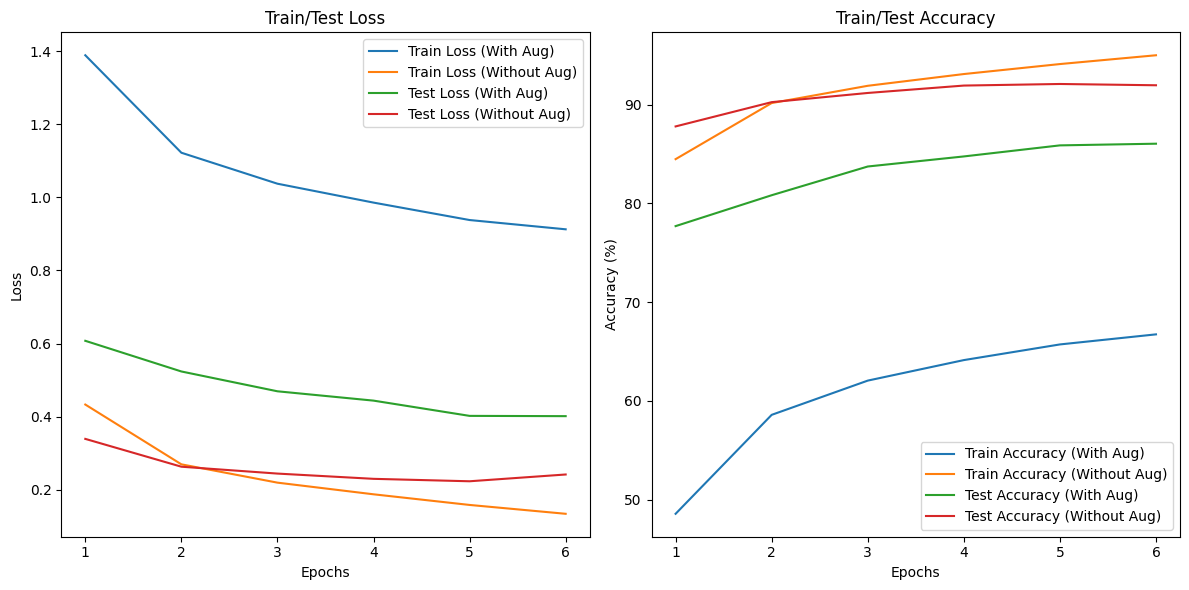

In [88]:
# Построение графиков для сравнения результатов с трансформациями и без

epochs_range = range(1, num_epochs + 1)

plt.figure(figsize=(12, 6))

# График потерь (Train/Test Loss)
plt.subplot(1, 2, 1)
plt.plot(epochs_range, results_with_aug['train_loss'], label='Train Loss (With Aug)')
plt.plot(epochs_range, results_without_aug['train_loss'], label='Train Loss (Without Aug)')
plt.plot(epochs_range, results_with_aug['test_loss'], label='Test Loss (With Aug)')
plt.plot(epochs_range, results_without_aug['test_loss'], label='Test Loss (Without Aug)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train/Test Loss')
plt.legend()

# График точности (Train/Test Accuracy)
plt.subplot(1, 2, 2)
plt.plot(epochs_range, results_with_aug['train_acc'], label='Train Accuracy (With Aug)')
plt.plot(epochs_range, results_without_aug['train_acc'], label='Train Accuracy (Without Aug)')
plt.plot(epochs_range, results_with_aug['test_acc'], label='Test Accuracy (With Aug)')
plt.plot(epochs_range, results_without_aug['test_acc'], label='Test Accuracy (Without Aug)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Train/Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# Анализ результатов обучения модели с и без аугментации данных

На графиках отображены результаты обучения модели с применением аугментации данных (с трансформациями) и без аугментации (только базовое преобразование данных) на протяжении 6 эпох. Рассмотрим, что можно наблюдать на каждом из графиков.

## 1. Train/Test Loss (Потери)
- **Train Loss (With Augmentation)** — синяя линия: Потери на тренировочных данных с аугментацией данных уменьшаются медленнее по сравнению с моделью без аугментации. Это связано с тем, что трансформации усложняют задачу обучения, добавляя вариативность в данные, что замедляет процесс обучения.

- **Train Loss (Without Augmentation)** — оранжевая линия: Потери на тренировочных данных без аугментации уменьшаются быстрее. Модель видит одни и те же данные, что упрощает задачу обучения, но также увеличивает риск переобучения.

- **Test Loss (With Augmentation)** — зелёная линия: Потери на тестовых данных с аугментацией уменьшаются и остаются ниже по сравнению с моделью без аугментации. Это указывает на лучшее обобщение модели на тестовых данных благодаря разнообразию данных в процессе обучения.

- **Test Loss (Without Augmentation)** — красная линия: Потери на тестовых данных без аугментации стабилизируются на низком уровне, но начинают увеличиваться, что может указывать на переобучение модели.

## 2. Train/Test Accuracy (Точность)
- **Train Accuracy (With Augmentation)** — синяя линия: Точность на тренировочных данных с аугментацией растёт медленнее из-за увеличения сложности задачи, связанной с аугментацией данных. Модель видит больше вариаций данных, что делает обучение сложнее, но улучшает обобщение.

- **Train Accuracy (Without Augmentation)** — оранжевая линия: Точность на тренировочных данных без аугментации растёт быстрее, так как модель видит однородные данные и быстрее подстраивается под них. Однако это увеличивает риск переобучения.

- **Test Accuracy (With Augmentation)** — зелёная линия: Точность на тестовых данных с аугментацией стабильно растёт, демонстрируя лучшие результаты обобщения, чем модель без аугментации.

- **Test Accuracy (Without Augmentation)** — красная линия: Точность на тестовых данных без аугментации выше на начальных этапах, но со временем начинает стабилизироваться, демонстрируя меньшее улучшение, чем у модели с аугментацией.

## Разница между моделями:
- **С трансформациями**: Модель с аугментацией данных обобщает лучше, имеет более низкие тестовые потери и более высокую тестовую точность. Это указывает на её лучшую способность справляться с новыми, невидимыми данными.
- **Без трансформаций**: Модель без аугментации данных быстрее достигает высокой точности на тренировочных данных, но это может быть признаком переобучения. Она хуже справляется с тестовыми данными, показывая более высокие потери и меньшую точность на тестовом наборе.

### Вывод:
Аугментация данных помогает модели лучше обобщать и снижает риск переобучения, особенно когда тренировочный набор данных небольшой или недостаточно разнообразный. Без аугментации модель может показать лучшие результаты на тренировочных данных, но её способность обобщать будет ограничена.
